In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from skimage.feature import hog
from skimage import exposure
from skimage.transform import rotate
import pickle
from tqdm import tqdm
import timeit
from joblib import Parallel, delayed
import os
%matplotlib inline

## Utils

### Read csv file function

In [2]:
''' Function to read csv file and return pixels and labels.'''

def read_file(filename, hist=False):
    
    # if hist=True, images will be load in Image Histogram, a vector has 256 elements
    
    df = pd.read_csv(filename)
    if hist:
        pixels = np.empty((df.shape[0], 256))
        for i in range(df.shape[0]):
            tmp = df.iloc[i].value_counts(sort=False).reindex(range(0, 256), fill_value=0).to_numpy()
            pixels[i] = tmp
    else:
        pixels = df.drop(columns=['label']).values

    labels = df.label.values
    pixels = pixels.astype(np.float64)

    # Pixels are the X values (either raw pixels or histograms, depending on hist parameter)
    # Labels are the y values (0-24 for each letter)
    
    return pixels, labels

### Load and save function

In [3]:
# Functions to save and load pickle files
# Pickle is a way to serialize and deserialize Python objects
# It is useful for saving machine learning models and datasets

''' Save function writes data to a pickle file '''

def save_pickle(data, filename):
    pickle.dump(data, open(filename, 'wb'))


''' Load function reads data from a pickle file '''

def load_pickle(filename):
    return pickle.load(open(filename, 'rb'))


### Visualization function

In [4]:
# Functions to show images by range meaning from start to end index
# or by condition meaning by specific labels

def show_image_by_range(pixels, labels, start=0, end=1, img_size=28):
    """
        Show images in range from start to end.
    """
    pixels_tmp = pixels.reshape(-1, img_size, img_size, 1)
    plt.figure(figsize=(12, 12))

    for i in range(start, end):
        plt.subplot((end - start) // 4 + 1, 4, i + 1)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(pixels_tmp[i, :, :, 0], cmap='gray')

    plt.show()

def show_image_by_condition( pixels, labels, label_condition=None, numbers=24, img_size=28):
    """
        Show images by label
    """
    label_to_letter = {i: chr(65 + i) for i in range(26)}

    pixels_tmp = pixels.reshape(-1, img_size, img_size, 1)
    plt.figure(figsize=(12, 12))

    cnt = 0
    if label_condition is None:
        label_condition_set = set(np.unique(labels))
    else:
        label_condition_set = set(label_condition)


    n_images = len(pixels)
    n_condition = len(label_condition_set)
    cached_label = set()
    while cnt < numbers:
        idx = np.random.randint(0, n_images)
        if labels[idx] in label_condition_set and (labels[idx] not in cached_label or cnt >= n_condition):
            cnt += 1
            cached_label.add(labels[idx])
            plt.subplot(numbers // 4 + 1, 4, cnt)
            plt.axis('off')
            plt.title(label_to_letter[labels[idx]])
            plt.imshow(pixels_tmp[idx, :, :, 0], cmap='gray')

    plt.show()

## Read and show data

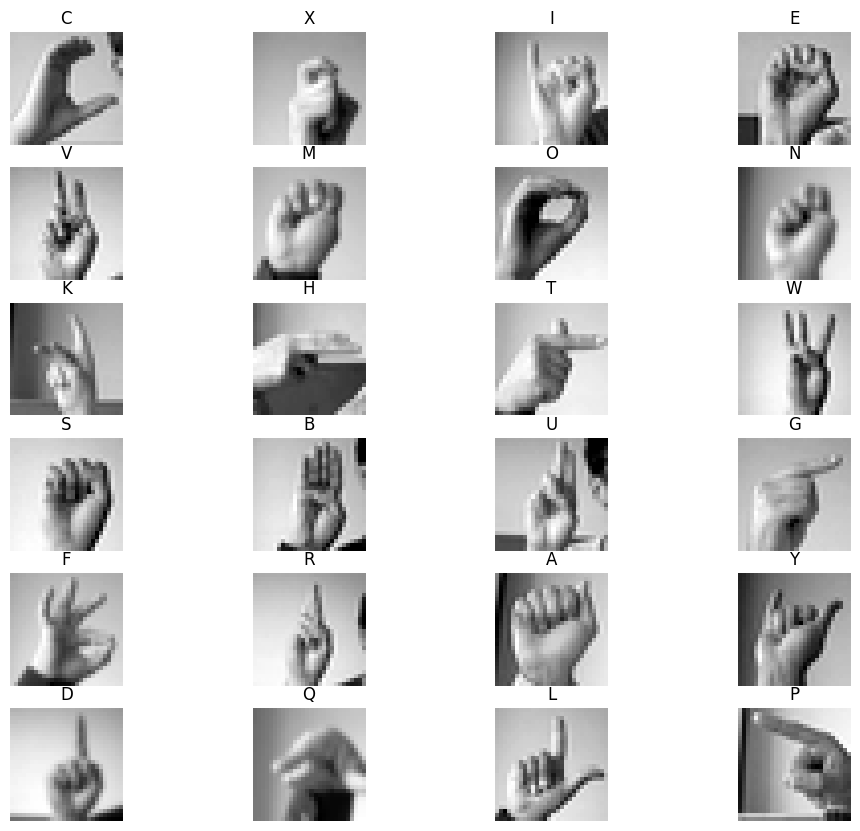

In [5]:
# read data from csv file
X_train, y_train = read_file('archive/sign_mnist_train.csv')
X_test, y_test = read_file('archive/sign_mnist_test.csv')

# normalize data from 0 to 1 range 
X_train /= 255
X_test /= 255

# Visualize images
show_image_by_condition(X_train, y_train , numbers=24)

### Baseline

I build a baseline model with default hyperparameters

In [6]:
# Train baseline model
start = timeit.default_timer()

model = LogisticRegression(penalty='l2', C=0.01, max_iter=2000, solver='lbfgs')

scores = cross_val_score(model, X_train, y_train, cv=5)

model.fit(X_train, y_train)


end = timeit.default_timer()
print("Fit time:", end - start)
print("Accuracy: %.4f" % (scores.mean() * 100))


print("test results")
#number of test examples
m_test= X_test.shape[0]
# add an extra column of 1´s corresponding to xo=1 (aka intercept term)


Fit time: 173.08680959997582
Accuracy: 83.5076
test results


In [8]:
y_pred = model.predict(X_test)
print("Accuracy: %.2f" % (accuracy_score(y_test, y_pred) * 100))

Accuracy: 67.09


In [10]:
start = timeit.default_timer()

model = SGDClassifier(
    loss='log_loss',      # logistic regression objective
    alpha=0.0001,         #s(λ)
    eta0=0.01,            # learning rate (α)
    learning_rate='constant',  # can also be 'invscaling' or 'adaptive'
    max_iter=1000,
    tol=1e-3,
)
model.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=5)
end = timeit.default_timer()
print("Fit time:", end - start)
print("Accuracy: %.4f" % (scores.mean() * 100))

KeyboardInterrupt: 

### Feature Extraction: Experiment with Image Histogram

In [ ]:
# Read image histogram
X_train_hist, y_train_hist = read_file('archive/sign_mnist_train.csv', hist=True)

In [ ]:
# Train model with histogram features
start = timeit.default_timer()

histogram_model = LogisticRegression(max_iter=10000, solver='lbfgs')
scores = cross_val_score(histogram_model, X_train_hist, y_train_hist, cv=5)


end = timeit.default_timer()
print("Fit time:", end - start)
print("Accuracy: %.2f" % (scores.mean() * 100))

Fit time: 199.04140560002998
Accuracy: 75.27


### Feature Extraction: Experiment with Histogram of Oriented Gradient

In [ ]:
def extract_hog(img, img_size=28, orientations=9, pixels_per_cell=(2, 2), cells_per_block=(1, 1)):
    """
        Histogram of Oriented Gradients
    """
    fd = hog(img.reshape((img_size, img_size)), orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=False)

    return fd

def call_parallel_extraction(images):
    """
        Process images parallelly
    """
    features = Parallel(n_jobs=os.cpu_count())(delayed(extract_hog)(img) for img in tqdm(images))
    return np.array(features)

Show feature images to choose size of cell and size of block

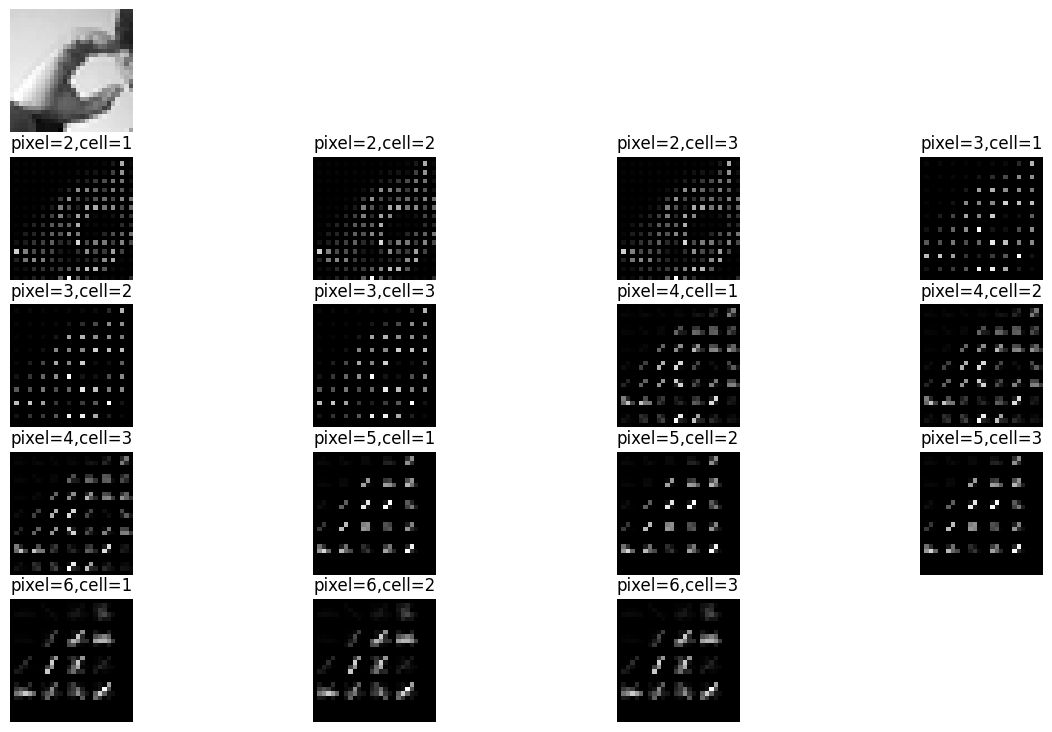

In [ ]:
# Show hog features
represent_index = 3
plt.figure(figsize=(15, 15))
plt.subplot(8, 4, 1)
plt.imshow(X_train[represent_index].reshape(28, 28), cmap='gray')
plt.axis('off')
cnt = 2
for n_pixel in range(2, 7):
    for n_cell in range(1, 4):
        _, represent_hog = hog(X_train[represent_index: 4].reshape((28, 28)), orientations=9, pixels_per_cell=(n_pixel, n_pixel), cells_per_block=(n_cell, n_cell), visualize=True)
        plt.subplot(8, 4, cnt + 3)
        cnt += 1
        plt.title('pixel=' + str(n_pixel) + ',cell=' + str(n_cell))
        plt.imshow(represent_hog, cmap='gray')
        plt.axis('off')
plt.show()

In [ ]:
# Features extraction using HOG
X_train_hog = call_parallel_extraction(X_train)
X_test_hog = call_parallel_extraction(X_test)

100%|██████████| 7172/7172 [00:36<00:00, 197.77it/s]


In [ ]:
# Train model again
start = timeit.default_timer()

model = LogisticRegression(max_iter=10000, solver='lbfgs')
model.fit(X_train_hog, y_train)

end = timeit.default_timer()
print("Fit time:", end - start)

y_pred = model.predict(X_test_hog)
print("Accuracy: %.2f" % (accuracy_score(y_test, y_pred) * 100))

c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fit time: 9.43712969997432
Accuracy: 85.08


Visualize confusion matrix to see which labels have many misclassified

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred = y_pred)
plt.figure(figsize=(12,12))
sns.heatmap(cm, annot=True, 
            linewidths=.5, square = True, cmap = 'Blues_r', fmt='0.4g')

plt.title('Confusion Matrix', size = 15)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 192.72222222222217, 'Predicted label')

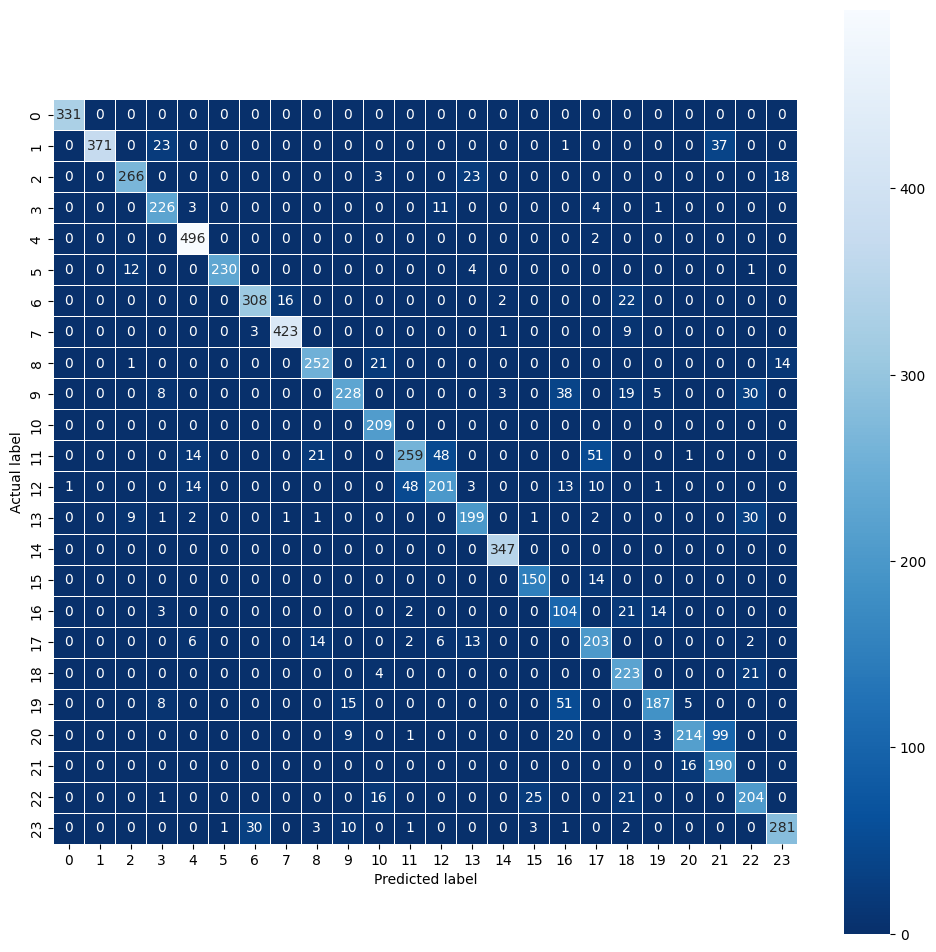

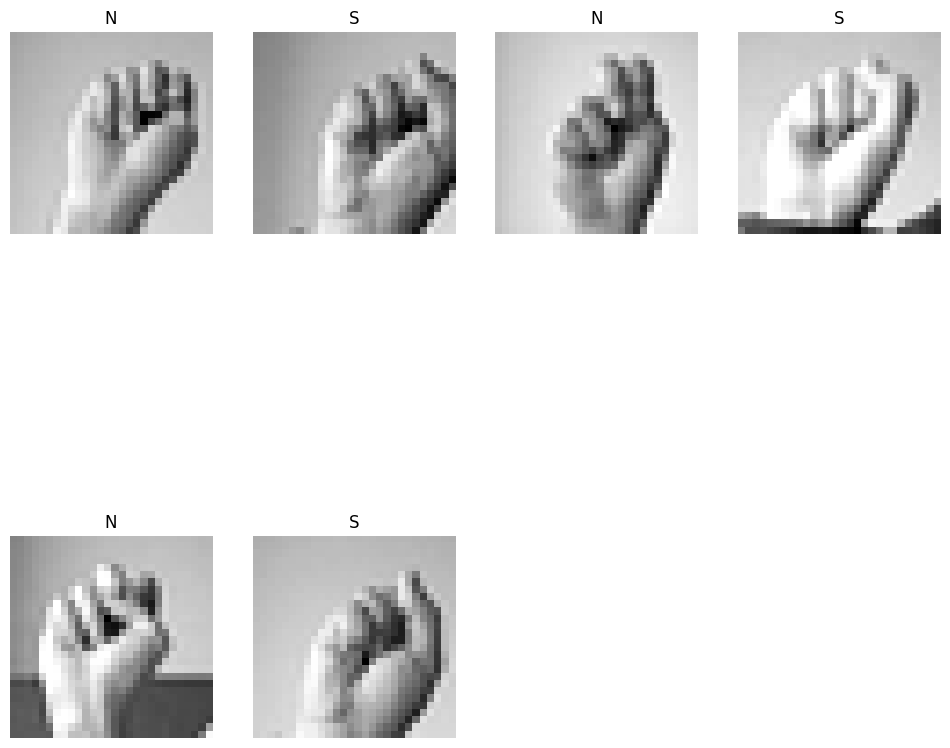

In [ ]:
show_image_by_condition(X_test, y_test, label_condition=[13, 18], numbers=8)

### Find good model hyperparameters

In [ ]:
# Set up hyperparameters
params = []
for n_component in np.arange(300, 1000, 50):
    for C_value in np.logspace(-3, 3, 7):
        params.append({
        "pca__n_components" : n_component,
        "clf__estimator__C" : C_value 
        })

best_score = 0
best_param = None

# Loop through hyperparameters and choose the best fit
for param in params:
    pipeline = Pipeline([
                      ('pca', PCA()),
                      ('clf', OneVsOneClassifier(
                          LogisticRegression(max_iter=10000, solver='lbfgs', multi_class='auto'))
                      )
    ])

    pipeline.set_params(**param)
    start = timeit.default_timer()
    pipeline.fit(X_train_hog, y_train)
    stop = timeit.default_timer()
    print("=============")
    print("Param", param)
    print("Training time: %.2f" % (stop - start))
    curr_score = pipeline.score(X_test_hog, y_test)
    print("Accuracy: %.2f" % (curr_score * 100))
    if curr_score > best_score:
        best_param = param
        best_score = curr_score

print("Best param:", best_param)

c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 300, 'clf__estimator__C': 0.001}
Training time: 12.16
Accuracy: 74.87


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 300, 'clf__estimator__C': 0.01}
Training time: 16.04
Accuracy: 84.68


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 300, 'clf__estimator__C': 0.1}
Training time: 14.56
Accuracy: 86.38


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 300, 'clf__estimator__C': 1.0}
Training time: 14.59
Accuracy: 87.49


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 300, 'clf__estimator__C': 10.0}
Training time: 14.58
Accuracy: 87.44


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 300, 'clf__estimator__C': 100.0}
Training time: 11.55
Accuracy: 87.81


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 300, 'clf__estimator__C': 1000.0}
Training time: 10.87
Accuracy: 87.24


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 350, 'clf__estimator__C': 0.001}
Training time: 12.47
Accuracy: 75.32


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 350, 'clf__estimator__C': 0.01}
Training time: 13.89
Accuracy: 84.34


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 350, 'clf__estimator__C': 0.1}
Training time: 16.50
Accuracy: 86.60


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 350, 'clf__estimator__C': 1.0}
Training time: 18.45
Accuracy: 87.14


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 350, 'clf__estimator__C': 10.0}
Training time: 34.26
Accuracy: 87.63


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 350, 'clf__estimator__C': 100.0}
Training time: 38.83
Accuracy: 87.42


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 350, 'clf__estimator__C': 1000.0}
Training time: 15.68
Accuracy: 87.70


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 400, 'clf__estimator__C': 0.001}
Training time: 22.36
Accuracy: 75.33


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 400, 'clf__estimator__C': 0.01}
Training time: 31.67
Accuracy: 84.19


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 400, 'clf__estimator__C': 0.1}
Training time: 17.82
Accuracy: 85.71


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 400, 'clf__estimator__C': 1.0}
Training time: 20.25
Accuracy: 86.57


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 400, 'clf__estimator__C': 10.0}
Training time: 34.80
Accuracy: 86.78


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 400, 'clf__estimator__C': 100.0}
Training time: 17.24
Accuracy: 86.71


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 400, 'clf__estimator__C': 1000.0}
Training time: 14.74
Accuracy: 87.01


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 450, 'clf__estimator__C': 0.001}
Training time: 21.54
Accuracy: 75.29


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 450, 'clf__estimator__C': 0.01}
Training time: 29.32
Accuracy: 83.71


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 450, 'clf__estimator__C': 0.1}
Training time: 23.99
Accuracy: 86.57


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 450, 'clf__estimator__C': 1.0}
Training time: 17.31
Accuracy: 87.06


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 450, 'clf__estimator__C': 10.0}
Training time: 18.75
Accuracy: 86.81


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 450, 'clf__estimator__C': 100.0}
Training time: 16.25
Accuracy: 87.30


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 450, 'clf__estimator__C': 1000.0}
Training time: 20.12
Accuracy: 86.87


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 500, 'clf__estimator__C': 0.001}
Training time: 29.85
Accuracy: 75.60


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 500, 'clf__estimator__C': 0.01}
Training time: 50.09
Accuracy: 83.87


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 500, 'clf__estimator__C': 0.1}
Training time: 23.64
Accuracy: 85.88


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 500, 'clf__estimator__C': 1.0}
Training time: 26.33
Accuracy: 87.06


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 500, 'clf__estimator__C': 10.0}
Training time: 30.58
Accuracy: 86.64


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 500, 'clf__estimator__C': 100.0}
Training time: 16.26
Accuracy: 87.23


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 500, 'clf__estimator__C': 1000.0}
Training time: 15.44
Accuracy: 86.88


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 550, 'clf__estimator__C': 0.001}
Training time: 18.08
Accuracy: 75.47


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 550, 'clf__estimator__C': 0.01}
Training time: 23.21
Accuracy: 83.76


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 550, 'clf__estimator__C': 0.1}
Training time: 49.98
Accuracy: 85.85


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 550, 'clf__estimator__C': 1.0}
Training time: 20.16
Accuracy: 86.52


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 550, 'clf__estimator__C': 10.0}
Training time: 29.54
Accuracy: 86.70


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 550, 'clf__estimator__C': 100.0}
Training time: 32.27
Accuracy: 86.91


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 550, 'clf__estimator__C': 1000.0}
Training time: 18.46
Accuracy: 87.07


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 600, 'clf__estimator__C': 0.001}
Training time: 19.49
Accuracy: 75.64


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 600, 'clf__estimator__C': 0.01}
Training time: 22.46
Accuracy: 83.60


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 600, 'clf__estimator__C': 0.1}
Training time: 32.80
Accuracy: 85.82


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 600, 'clf__estimator__C': 1.0}
Training time: 42.49
Accuracy: 86.81


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 600, 'clf__estimator__C': 10.0}
Training time: 20.04
Accuracy: 86.95


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 600, 'clf__estimator__C': 100.0}
Training time: 22.80
Accuracy: 86.89


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 600, 'clf__estimator__C': 1000.0}
Training time: 29.68
Accuracy: 86.75


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 650, 'clf__estimator__C': 0.001}
Training time: 53.39
Accuracy: 75.60


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 650, 'clf__estimator__C': 0.01}
Training time: 29.55
Accuracy: 83.55


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 650, 'clf__estimator__C': 0.1}
Training time: 43.85
Accuracy: 85.92


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 650, 'clf__estimator__C': 1.0}
Training time: 22.24
Accuracy: 86.75


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 650, 'clf__estimator__C': 10.0}
Training time: 20.07
Accuracy: 86.61


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 650, 'clf__estimator__C': 100.0}
Training time: 21.02
Accuracy: 86.68


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 650, 'clf__estimator__C': 1000.0}
Training time: 29.80
Accuracy: 86.82


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 700, 'clf__estimator__C': 0.001}
Training time: 64.18
Accuracy: 75.75


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 700, 'clf__estimator__C': 0.01}
Training time: 26.44
Accuracy: 83.83


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 700, 'clf__estimator__C': 0.1}
Training time: 35.70
Accuracy: 85.74


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 700, 'clf__estimator__C': 1.0}
Training time: 30.24
Accuracy: 86.02


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 700, 'clf__estimator__C': 10.0}
Training time: 22.12
Accuracy: 86.88


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 700, 'clf__estimator__C': 100.0}
Training time: 27.88
Accuracy: 86.75


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 700, 'clf__estimator__C': 1000.0}
Training time: 30.74
Accuracy: 87.06


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 750, 'clf__estimator__C': 0.001}
Training time: 27.93
Accuracy: 75.74


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 750, 'clf__estimator__C': 0.01}
Training time: 28.63
Accuracy: 83.67


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 750, 'clf__estimator__C': 0.1}
Training time: 24.55
Accuracy: 85.72


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 750, 'clf__estimator__C': 1.0}
Training time: 22.71
Accuracy: 86.14


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 750, 'clf__estimator__C': 10.0}
Training time: 22.45
Accuracy: 86.54


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 750, 'clf__estimator__C': 100.0}
Training time: 34.87
Accuracy: 87.06


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 750, 'clf__estimator__C': 1000.0}
Training time: 89.28
Accuracy: 86.75


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 800, 'clf__estimator__C': 0.001}
Training time: 37.30
Accuracy: 75.60


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 800, 'clf__estimator__C': 0.01}
Training time: 52.46
Accuracy: 83.42


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 800, 'clf__estimator__C': 0.1}
Training time: 28.17
Accuracy: 85.67


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 800, 'clf__estimator__C': 1.0}
Training time: 27.70
Accuracy: 86.35


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 800, 'clf__estimator__C': 10.0}
Training time: 36.99
Accuracy: 86.67


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 800, 'clf__estimator__C': 100.0}
Training time: 27.30
Accuracy: 86.68


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 800, 'clf__estimator__C': 1000.0}
Training time: 24.38
Accuracy: 86.85


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 850, 'clf__estimator__C': 0.001}
Training time: 29.68
Accuracy: 75.56


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 850, 'clf__estimator__C': 0.01}
Training time: 46.35
Accuracy: 83.31


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 850, 'clf__estimator__C': 0.1}
Training time: 35.33
Accuracy: 85.47


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 850, 'clf__estimator__C': 1.0}
Training time: 30.10
Accuracy: 86.15


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 850, 'clf__estimator__C': 10.0}
Training time: 37.13
Accuracy: 86.29


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 850, 'clf__estimator__C': 100.0}
Training time: 39.82
Accuracy: 86.70


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 850, 'clf__estimator__C': 1000.0}
Training time: 27.68
Accuracy: 86.94


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 900, 'clf__estimator__C': 0.001}
Training time: 37.44
Accuracy: 75.64


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 900, 'clf__estimator__C': 0.01}
Training time: 69.27
Accuracy: 83.24


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 900, 'clf__estimator__C': 0.1}
Training time: 40.55
Accuracy: 85.49


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 900, 'clf__estimator__C': 1.0}
Training time: 52.61
Accuracy: 85.97


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 900, 'clf__estimator__C': 10.0}
Training time: 30.37
Accuracy: 86.36


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 900, 'clf__estimator__C': 100.0}
Training time: 36.67
Accuracy: 86.59


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 900, 'clf__estimator__C': 1000.0}
Training time: 54.87
Accuracy: 86.71


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 950, 'clf__estimator__C': 0.001}
Training time: 27.76
Accuracy: 75.91


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 950, 'clf__estimator__C': 0.01}
Training time: 28.07
Accuracy: 83.32


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 950, 'clf__estimator__C': 0.1}
Training time: 29.88
Accuracy: 85.67


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 950, 'clf__estimator__C': 1.0}
Training time: 30.47
Accuracy: 86.15


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 950, 'clf__estimator__C': 10.0}
Training time: 45.53
Accuracy: 86.22


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 950, 'clf__estimator__C': 100.0}
Training time: 66.40
Accuracy: 86.53


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Param {'pca__n_components': 950, 'clf__estimator__C': 1000.0}
Training time: 39.43
Accuracy: 86.50
Best param: {'pca__n_components': 300, 'clf__estimator__C': 100.0}


After ran this code, I decided to choose C=1000 and PCA_n_components=950

## Final

In [ ]:
CONFIGS = {
    'C' : 1000,
    'MAX_ITER' : 10000,
    'N_COMPONENTS' : 950,
}

def train(X_train, y_train, model=None):
    """
        Build and train model.
    """

    X_train = call_parallel_extraction(X_train)

    print("=====TRAINING=====")
    if model is None:
        print("Step 0: Initializing model...")
        model = Pipeline([
                            ('pca', PCA(n_components=CONFIGS['N_COMPONENTS'])),
                            ('clf', OneVsOneClassifier(
                                LogisticRegression(C=CONFIGS['C'], 
                                                   max_iter=CONFIGS['MAX_ITER'], 
                                                   solver='lbfgs', multi_class='auto')))
        ])

    print("Step 1: Start training model...")
    model.fit(X_train, y_train)

    print("Finished training model!")
    return model

def predict(X_test, y_test, model=None):
    """
        Evaluation function.
    """

    X_test = call_parallel_extraction(X_test)

    print("=====PREDICTION=====")
    if model is None: 
        print("Step 0: Start loading model...")
        model = load_pickle(CONFIGS['MODEL_PATH'])

    print("Step 1: Predicting...")
    y_pred = model.predict(X_test)

    print("Step 2: Scoring model...")
    missed_labels = np.sum(y_pred != y_test)
    accuracy = accuracy_score(y_test, y_pred)

    print("Accuracy: {:.5f}".format(accuracy))
    print("Missed Label: ", missed_labels)

    print("Finished predicting model!")
    return accuracy, missed_labels


## Training and Evaluate

In [ ]:
# read data from csv file
X_train, y_train = read_file('archive/sign_mnist_train.csv')
X_test, y_test = read_file('archive/sign_mnist_test.csv')

# normalize data from 0 to 1 range 
X_train /= 255
X_test /= 255

# train
model = train(X_train, y_train)

# get test score
_ = predict(X_test, y_test, model)

100%|██████████| 27455/27455 [00:46<00:00, 592.34it/s]


=====TRAINING=====
Step 0: Initializing model...
Step 1: Start training model...


c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\30697\miniconda3\envs\compgeo2025\Lib\site-packages\sklearn\linear_model\

Finished training model!


100%|██████████| 7172/7172 [00:17<00:00, 409.84it/s]


=====PREDICTION=====
Step 1: Predicting...
Step 2: Scoring model...
Accuracy: 0.86712
Missed Label:  953
Finished predicting model!
